# Training Vanilla GAN on CIFAR-10

In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
!pip install torch-summary
from torchsummary import summary
from torchvision.utils import save_image

import gitpath
HOME_PATH = gitpath.root()
sys.path.append(HOME_PATH)

from models.DCGAN import *

In [2]:
class HyperParams:
    def __init__(self):
        # Constance hyperparameters. They have been tested and don't need to be tuned.
        self.n_epochs = 50
        self.batch_size = 64
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_workers = 8
        self.latent_dim = 100
        self.img_size = 32
        self.channels = 3
        self.sample_interval = 500
        self.imgsave_path = os.path.join(HOME_PATH, 'images', 'dcgan')
        self.CHECKPOINT_FOLDER = os.path.join(HOME_PATH, 'saved_model', 'dcgan')
        
params = HyperParams()
os.makedirs(params.imgsave_path, exist_ok=True)
os.makedirs(params.CHECKPOINT_FOLDER, exist_ok=True)

## Step 1: Set up preprocessing functions

In [3]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ])

In [4]:
# do NOT change these
import torchvision.datasets as dset
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = os.path.join(HOME_PATH, "data")

# construct dataset
dataset = dset.CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform 
)

# construct dataloader
dataloader = DataLoader(
    dataset, 
    batch_size=params.batch_size,  # your code
    shuffle=True,     # your code
    num_workers=params.n_workers
)

Files already downloaded and verified


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.

In [5]:
# specify the device for computation

# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
generator = Generator(params.latent_dim).to(device)
discriminator = Discriminator().to(device)

# Check if on GPU
assert(next(generator.parameters()).is_cuda)
assert(next(discriminator.parameters()).is_cuda)

Run on GPU...


## Step 4: Set up the loss function and optimizer

In [6]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters according to ResNet paper section 4.2

# create loss function
criterion = nn.BCELoss().to(device)

# Add optimizer
optimizerG = optim.Adam(generator.parameters(), lr=params.lr, betas=(params.b1, params.b2))
optimizerD = optim.Adam(discriminator.parameters(), lr=params.lr, betas=(params.b1, params.b2))

## Step 5: Start the training process.


In [9]:
# some hyperparameters
# total number of training epochs
start_epoch = 0

# start the training/validation process
best_loss_g = 1e20
best_loss_d = 1e20

start = time.time()
print("==> Training starts!")
print("="*50)

# store loss learning curve
g_loss_lst = []
d_loss_lst = []

fixed_random_z = torch.randn(params.batch_size, params.latent_dim).to(device)

for i in range(start_epoch, params.n_epochs):
    epoch_start = time.time()
    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    g_loss = []
    d_loss = []
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        
        inputs = inputs.float().to(device)
        batch_size = inputs.size(0)
        
        real_labels = torch.full((batch_size,1), 1.0).to(device)
        fake_labels = torch.full((batch_size,1), 0.0).to(device)
        
        ####################################
        # Train Generator
        ###################################
        # maximize generator's ability to fool discriminator
        z = torch.randn(batch_size, params.latent_dim).to(device)
        gen_imgs = generator(z)
        fake_outputs = discriminator(gen_imgs)
        loss_G = criterion(fake_outputs, real_labels)
        
        # zero the gradient
        optimizerG.zero_grad()
        # backpropagation
        loss_G.backward()
        # apply gradient and update the weights
        optimizerG.step()

        # calculate percentage of confidence
        G_z = fake_outputs.mean().item()
        g_loss.append(loss_G.cpu().detach().numpy())
        ####################################
        
        ####################################
        # Train Discriminator
        ###################################
        # train to recog real image
        real_outputs = discriminator(inputs)
        loss_real = criterion(real_outputs, real_labels)
        
        ###################################
        # train to recog fake image
        fake_outputs = discriminator(gen_imgs.detach())
        loss_fake = criterion(fake_outputs, fake_labels)
        
        # sum loss
        loss_D = (loss_fake + loss_real) / 2
        # zero the gradient
        optimizerD.zero_grad()
        # backpropagation
        loss_D.backward()
        # apply gradient and update the weights
        optimizerD.step()

        # calculate percentage of confidence
        D_x = real_outputs.mean().item()
        D_z = fake_outputs.mean().item()
        d_loss.append(loss_D.cpu().detach().numpy())
        
        ####################################
        
        if (batch_idx % params.sample_interval == 0): 
            batches_done = i * len(dataloader) + batch_idx
            save_image(generator(fixed_random_z).data[:40], os.path.join(params.imgsave_path, "%d.png" % batches_done), nrow=5, normalize=True)
            print("D(x): %.4f D(G(z)): %.4f / %.4f"%(D_x, D_z, G_z))
        
    avg_loss_g = np.sum(np.asarray(g_loss)) / len(g_loss)
    avg_loss_d = np.sum(np.asarray(d_loss)) / len(d_loss)
    print("Generator loss: %.4f, Discriminator loss: %.4f"%(avg_loss_g, avg_loss_d))
    
    g_loss_lst.append(avg_loss_g)
    d_loss_lst.append(avg_loss_d)
    
    # save the model checkpoint
    state_G = generator.state_dict()
    torch.save(state_G, os.path.join(params.CHECKPOINT_FOLDER, 'generator.pth'))
    state_D = discriminator.state_dict()
    torch.save(state_D, os.path.join(params.CHECKPOINT_FOLDER, 'discriminator.pth'))
    print(f"Epoch finished in {time.time() - epoch_start:.2f}s")
    print("")

print("="*50)
print(f"==> Optimization finished in {time.time() - start:.2f}s!")

==> Training starts!
Epoch 0:
D(x): 0.4898 D(G(z)): 0.5020 / 0.5020
D(x): 0.6826 D(G(z)): 0.0377 / 0.0377
Generator loss: 2.8400, Discriminator loss: 0.1753
Epoch finished in 31.41s
Epoch 1:
D(x): 0.9472 D(G(z)): 0.5213 / 0.5213
D(x): 0.9637 D(G(z)): 0.3784 / 0.3784
Generator loss: 2.8220, Discriminator loss: 0.2043
Epoch finished in 56.51s
Epoch 2:
D(x): 0.9821 D(G(z)): 0.2053 / 0.2053
D(x): 0.9394 D(G(z)): 0.0787 / 0.0787
Generator loss: 3.3278, Discriminator loss: 0.1369
Epoch finished in 83.45s
Epoch 3:
D(x): 0.8947 D(G(z)): 0.0347 / 0.0347
D(x): 0.3347 D(G(z)): 0.0018 / 0.0018
Generator loss: 3.3820, Discriminator loss: 0.1407
Epoch finished in 108.19s
Epoch 4:
D(x): 0.9950 D(G(z)): 0.3654 / 0.3654
D(x): 0.9836 D(G(z)): 0.2282 / 0.2282
Generator loss: 3.6460, Discriminator loss: 0.1191
Epoch finished in 136.36s
Epoch 5:
D(x): 0.9949 D(G(z)): 0.1993 / 0.1993
D(x): 0.9894 D(G(z)): 0.1991 / 0.1991
Generator loss: 3.6386, Discriminator loss: 0.1270
Epoch finished in 162.83s
Epoch 6:
D

D(x): 0.9736 D(G(z)): 0.0282 / 0.0282
D(x): 0.8272 D(G(z)): 0.0037 / 0.0037
Generator loss: 4.9475, Discriminator loss: 0.0917
Epoch finished in 1430.28s
Epoch 51:
D(x): 0.9981 D(G(z)): 0.3080 / 0.3080
D(x): 0.9855 D(G(z)): 0.0149 / 0.0149
Generator loss: 4.9803, Discriminator loss: 0.0690
Epoch finished in 1455.51s
Epoch 52:
D(x): 0.9165 D(G(z)): 0.0195 / 0.0195
D(x): 0.9559 D(G(z)): 0.7846 / 0.7846
Generator loss: 4.9068, Discriminator loss: 0.1760
Epoch finished in 1480.47s
Epoch 53:
D(x): 0.9818 D(G(z)): 0.0147 / 0.0147
D(x): 0.9874 D(G(z)): 0.0401 / 0.0401
Generator loss: 4.8210, Discriminator loss: 0.0734
Epoch finished in 1510.01s
Epoch 54:
D(x): 0.9963 D(G(z)): 0.1546 / 0.1546
D(x): 0.9916 D(G(z)): 0.0731 / 0.0731
Generator loss: 4.9430, Discriminator loss: 0.1020
Epoch finished in 1535.54s
Epoch 55:
D(x): 0.8454 D(G(z)): 0.0062 / 0.0062
D(x): 0.9967 D(G(z)): 0.0328 / 0.0328
Generator loss: 4.7984, Discriminator loss: 0.0961
Epoch finished in 1561.32s
Epoch 56:
D(x): 1.0000 D(G

D(x): 0.9826 D(G(z)): 0.0493 / 0.0493
D(x): 0.9704 D(G(z)): 0.0551 / 0.0551
Generator loss: 5.5441, Discriminator loss: 0.0518
Epoch finished in 2684.57s
Epoch 101:
D(x): 0.9999 D(G(z)): 0.7653 / 0.7653
D(x): 0.9869 D(G(z)): 0.0185 / 0.0185
Generator loss: 5.4098, Discriminator loss: 0.0978
Epoch finished in 2706.32s
Epoch 102:
D(x): 0.9905 D(G(z)): 0.0436 / 0.0436
D(x): 0.9981 D(G(z)): 0.0060 / 0.0060
Generator loss: 5.5851, Discriminator loss: 0.0626
Epoch finished in 2728.08s
Epoch 103:
D(x): 0.9997 D(G(z)): 0.1875 / 0.1875
D(x): 0.9746 D(G(z)): 0.0227 / 0.0227
Generator loss: 5.4791, Discriminator loss: 0.0669
Epoch finished in 2749.81s
Epoch 104:
D(x): 0.8078 D(G(z)): 0.0008 / 0.0008
D(x): 0.9834 D(G(z)): 0.0042 / 0.0042
Generator loss: 5.6762, Discriminator loss: 0.0746
Epoch finished in 2771.60s
Epoch 105:
D(x): 0.9966 D(G(z)): 0.0253 / 0.0253
D(x): 0.9984 D(G(z)): 0.0866 / 0.0866
Generator loss: 5.5425, Discriminator loss: 0.0627
Epoch finished in 2793.37s
Epoch 106:
D(x): 0.99

D(x): 0.9995 D(G(z)): 0.1267 / 0.1267
D(x): 0.9990 D(G(z)): 0.1270 / 0.1270
Generator loss: 5.9630, Discriminator loss: 0.0482
Epoch finished in 3779.76s
Epoch 151:
D(x): 0.9932 D(G(z)): 0.0181 / 0.0181
D(x): 0.9832 D(G(z)): 0.0184 / 0.0184
Generator loss: 6.0163, Discriminator loss: 0.0747
Epoch finished in 3801.45s
Epoch 152:
D(x): 0.9900 D(G(z)): 0.0105 / 0.0105
D(x): 0.9847 D(G(z)): 0.0116 / 0.0116
Generator loss: 6.1845, Discriminator loss: 0.0476
Epoch finished in 3822.95s
Epoch 153:
D(x): 0.8897 D(G(z)): 0.0024 / 0.0024
D(x): 0.9720 D(G(z)): 0.0209 / 0.0209
Generator loss: 6.1681, Discriminator loss: 0.0840
Epoch finished in 3844.56s
Epoch 154:
D(x): 0.9952 D(G(z)): 0.1510 / 0.1510
D(x): 0.9757 D(G(z)): 0.0463 / 0.0463
Generator loss: 5.9063, Discriminator loss: 0.0548
Epoch finished in 3866.44s
Epoch 155:
D(x): 0.9665 D(G(z)): 0.0039 / 0.0039
D(x): 0.9997 D(G(z)): 0.0602 / 0.0602
Generator loss: 6.0426, Discriminator loss: 0.0773
Epoch finished in 3888.19s
Epoch 156:
D(x): 0.99

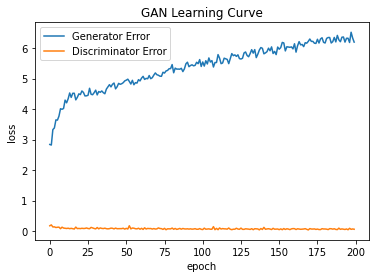

In [10]:
plt.plot(g_loss_lst, label='Generator Error')
plt.plot(d_loss_lst, label='Discriminator Error')
plt.title("GAN Learning Curve")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()